## Imports

In [1]:
import sys
sys.path.insert(0, "../src")

import preprocessing as prep
import vocab as vocab
import util as util
import model
from main import *
from tqdm import tqdm
import torch
import torch.utils.data
import os
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from timeit import default_timer as timer
import model
import preprocessing as prep
import argparse
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import json
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()



hparams = {
   # You can configure the following parameters.
   # Currently configured to load ...
   # Changing these parameter can force a new training
   "batch_size": 32,
   "rnn_layers" : 3,
   "shuffle" : True,
   "cnn_model": "resnet50",#values "vgg16", "mobilenet", "resnet50"
   "rnn_model": "gru",# "gru", "lstm"
   "improve_embedding": True,
   "improve_cnn": False,
   "image_size": 370,# between 256 and 640
   "crop_size": 320,# minimum 224, must be lower than "image_size"
   "caption_number" : 5, #number of captions to use in the dataset. between 1 and 5
   "cutoff": 2, # Minimum word frequency to not flag a word as unknwon
   "clip_grad": None,# set to 1.0 if NaN values appear during training
   "weight_decay": 0, # L2 Regularization
   "num_epochs": 75,
   "lr": 0.001,# learning rate
   "sgd_momentum": None,# 
   "break_training_loop_percentage": 10,
   "drop_out_prob" : 0,# only when "rnn_layers" > 1, otherwise set to 0
   "sampling_method": "",# either "beam_search", "beam_search_early_stop", "sample_search" or "" for a greedy search
   "beam_width": 3,
   "training_report_frequency" : 5,
   "last_saved_model" : "lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo75_bat32_do0_cut2_can5_with_norm_ie_s.pt",
   #Do not change the following parameters
   "use_pixel_normalization" : True,
   "compute_val_loss": True,
   "keep_best_val_loss": False,
   "keep_best_total_loss": True,
   "gold_eval_with_original": True,
   "device": "cuda:0",
   "root": "../data",
   "annotation_without_punctuation": False,
   "train": "train2017",
   "val": "val2017",
   "test": "test2017",
   "timestamp_prefix": "%d%b%Y_%H_%M_%S_%f",
   "debug": False,
   "print_prediction" : False,
   "save_eval_results" : False,
   "model_name": "_.pt",
   "use_glove": True,
   "use_padding_idx": True,
   "model_storage": "./model_storage",
   "glove_embedding": "glove.6B.300d.bin.word2vec",
   "save_pending_model" : False,
   "hidden_dim": 512,
   "embedding_dim" : 300,
   "use_tensorboard":False
}

#End - Do not change these!
HYPER_PARAMETER_CONFIG = "../hparams.json"
MODEL_STORAGE="../model_storage"
#hparams = prep.read_json_config(HYPER_PARAMETER_CONFIG)
ROOT="../data"
SEED = 1
PADDING_WORD="<MASK>"
hparams["root"]=ROOT
hparams["model_storage"]=MODEL_STORAGE
trainset_name = "train"
valset_name = "val"
testset_name = "test"
#End - Do not change these!


## Load Embeddings

In [2]:
torch.cuda.empty_cache()

device = hparams["device"]
if not torch.cuda.is_available():
    print("Warning, only CPU processing available!")
    device = "cpu"
else:
    print("CUDA GPU is available", "Number of machines:", torch.cuda.device_count())

#Makes results more reproducible
prep.set_seed_everywhere(SEED)

#Prepare the vectorizer, mapping words to indices and vice versa
cleaned_captions = prep.get_captions(hparams, trainset_name)
cutoff_for_unknown_words = hparams["cutoff"]
vectorizer = vocab.CaptionVectorizer.from_dataframe(cleaned_captions, cutoff_for_unknown_words)


#Creates embedding model
padding_idx = None
if (hparams["use_padding_idx"]):
    padding_idx = vectorizer.get_vocab()._token_to_idx[PADDING_WORD]
embedding = util.create_embedding(hparams, vectorizer, padding_idx)

CUDA GPU is available Number of machines: 1
loading annotations into memory...


0it [00:00, ?it/s]

Done (t=0.25s)
creating index...
index created!


296it [01:57,  2.51it/s]


Loading glove vectors...
GloVe embedding size: 300


## Training
It only loads trained data stored under:
model_storage/lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo75_bat32_do0_cut2_can5_with_norm_ie_s.pt.

Do not forget to download it from https://drive.google.com/file/d/1V_xn4pOJ4RQRLcVfLUgLQea_QCzw_PE4/view?usp=sharing

The file is named model.zip  and you will need to unzip it.

In [3]:
#Creates Data loaders
train_loader = util.CocoDatasetWrapper.create_dataloader(hparams, vectorizer, trainset_name)
#the pictures for the training set and the test set shares the same directory, "train2017"
test_loader = util.CocoDatasetWrapper.create_dataloader(hparams, vectorizer, testset_name, "train2017")
val_loader = util.CocoDatasetWrapper.create_dataloader(hparams, vectorizer, valset_name)

#Creates the network
network = model.RNNModel(hparams["hidden_dim"], pretrained_embeddings=embedding,
                         cnn_model=hparams["cnn_model"], rnn_layers=hparams["rnn_layers"],
                         rnn_model=hparams["rnn_model"], drop_out_prob=hparams["drop_out_prob"],
                         improve_cnn=hparams["improve_cnn"]).to(device)

#Either load previous state or starts a training
start_training = init_model(hparams, network, False)
break_training_loop_idx, break_val_loop_idx, break_test_loop_idx = get_stop_loop_indices(hparams, train_loader,
                                                                                         val_loader, test_loader)

#Training
if start_training:
    loss_function = nn.NLLLoss().to(device)
    train(hparams, loss_function, network, train_loader, device, break_training_loop_idx, val_loader)




Image dir: ../data\train2017
Caption file path: ../data\annotations\10_cleaned_captions_train2017.json
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Image dir: ../data\train2017
Caption file path: ../data\annotations\10_cleaned_captions_test2017.json
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Image dir: ../data\val2017
Caption file path: ../data\annotations\10_cleaned_captions_val2017.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Using resnet50...
Model save path: ../model_storage\lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo75_bat32_do0_cut2_can5_with_norm_ie_s.pt
Skip Training


## Evaluation (slow!)

In [4]:
# Evaluation Part    
#hparams["sampling_method"]=""
#model.BleuScorer.perform_whole_evaluation(hparams, train_loader, network, break_training_loop_idx, "train")
bleu.BleuScorer.perform_whole_evaluation(hparams, val_loader, network, break_test_loop_idx, "val")
bleu.BleuScorer.perform_whole_evaluation(hparams, test_loader, network, break_test_loop_idx, "test")

##########################################################

Run complete evaluation for: val


32it [00:15,  2.04it/s]
32it [00:15,  2.12it/s]
32it [00:15,  2.11it/s]
32it [00:16,  1.95it/s]
32it [00:15,  2.06it/s]
32it [00:15,  2.08it/s]
32it [00:14,  2.15it/s]
32it [00:15,  2.05it/s]
32it [00:14,  2.16it/s]
32it [00:15,  2.10it/s]
32it [00:15,  2.07it/s]
32it [00:14,  2.15it/s]
32it [00:14,  2.15it/s]
32it [00:14,  2.22it/s]
32it [00:15,  2.05it/s]
20it [00:08,  2.26it/s]
  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

{'testlen': 5244, 'reflen': 5059, 'guess': [5244, 4744, 4244, 3744], 'correct': [2826, 1083, 406, 165]}
ratio: 1.0365684917965927
Unweighted Current Bleu Scores:
      Bleu_1    Bleu_2    Bleu_3    Bleu_4
0  0.538902  0.350749  0.227465  0.150912
Weighted Current Bleu Scores:
 0.31700687777581055
Geometric Mean Current Bleu Score:
 0.28381538564959496

Run complete evaluation for: gold


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.13it/s]


{'testlen': 5171, 'reflen': 4985, 'guess': [5171, 4671, 4171, 3671], 'correct': [3299, 1409, 554, 206]}
ratio: 1.037311935807214
{'testlen': 5185, 'reflen': 5015, 'guess': [5185, 4685, 4185, 3685], 'correct': [3304, 1394, 527, 188]}
ratio: 1.0338983050845396
{'testlen': 5225, 'reflen': 5018, 'guess': [5225, 4725, 4225, 3725], 'correct': [3184, 1324, 501, 181]}
ratio: 1.0412514946191627
{'testlen': 5277, 'reflen': 5045, 'guess': [5277, 4777, 4277, 3777], 'correct': [3260, 1380, 556, 222]}
ratio: 1.0459861248759075
{'testlen': 5268, 'reflen': 5038, 'guess': [5268, 4768, 4268, 3768], 'correct': [3314, 1389, 549, 207]}
ratio: 1.0456530369192047
Unweighted Gold Bleu Scores:
 Bleu_1    0.626288
Bleu_2    0.427578
Bleu_3    0.285405
Bleu_4    0.188080
dtype: float64
Weighted Gold Bleu Scores:
 0.38183757045517475
Geometric Gold Bleu Scores:
 0.3462567768887823
##########################################################
##########################################################

Run complete ev

32it [00:14,  2.17it/s]
32it [00:15,  2.13it/s]
32it [00:14,  2.18it/s]
32it [00:15,  2.11it/s]
32it [00:14,  2.25it/s]
32it [00:15,  2.06it/s]
32it [00:14,  2.21it/s]
32it [00:15,  2.09it/s]
32it [00:14,  2.15it/s]
32it [00:14,  2.18it/s]
32it [00:14,  2.17it/s]
32it [00:14,  2.16it/s]
32it [00:15,  2.10it/s]
32it [00:15,  2.07it/s]
32it [00:15,  2.10it/s]
32it [00:15,  2.11it/s]
32it [00:14,  2.20it/s]
32it [00:14,  2.18it/s]
32it [00:15,  2.08it/s]
32it [00:14,  2.15it/s]
32it [00:14,  2.17it/s]
32it [00:14,  2.17it/s]
32it [00:14,  2.24it/s]
32it [00:14,  2.19it/s]
32it [00:15,  2.11it/s]
32it [00:15,  2.08it/s]
32it [00:15,  2.04it/s]
32it [00:16,  1.99it/s]
32it [00:15,  2.02it/s]
32it [00:15,  2.03it/s]
32it [00:15,  2.10it/s]
32it [00:14,  2.16it/s]
32it [00:15,  2.09it/s]
32it [00:14,  2.15it/s]
32it [00:15,  2.12it/s]
32it [00:15,  2.01it/s]
32it [00:15,  2.06it/s]
32it [00:14,  2.17it/s]
32it [00:15,  2.06it/s]
32it [00:14,  2.19it/s]
32it [00:15,  2.05it/s]
32it [00:15,  2.

{'testlen': 25035, 'reflen': 24048, 'guess': [25035, 22670, 20305, 17940], 'correct': [13352, 4957, 1697, 620]}
ratio: 1.0410429141716133
Unweighted Current Bleu Scores:
      Bleu_1    Bleu_2    Bleu_3    Bleu_4
0  0.533333  0.341494  0.213607  0.135473
Weighted Current Bleu Scores:
 0.30597683345513216
Geometric Mean Current Bleu Score:
 0.269440319549371

Run complete evaluation for: gold


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:24<00:00,  2.97it/s]


{'testlen': 24571, 'reflen': 23649, 'guess': [24571, 22206, 19841, 17476], 'correct': [15540, 6680, 2635, 986]}
ratio: 1.0389868493381944
{'testlen': 24694, 'reflen': 23681, 'guess': [24694, 22329, 19964, 17599], 'correct': [15551, 6586, 2594, 953]}
ratio: 1.0427769097588344
{'testlen': 24542, 'reflen': 23646, 'guess': [24542, 22177, 19812, 17447], 'correct': [15551, 6620, 2582, 956]}
ratio: 1.0378922439312763
{'testlen': 24650, 'reflen': 23690, 'guess': [24650, 22285, 19920, 17555], 'correct': [15427, 6559, 2565, 989]}
ratio: 1.0405234276065412
{'testlen': 24643, 'reflen': 23677, 'guess': [24643, 22278, 19913, 17548], 'correct': [15533, 6618, 2560, 931]}
ratio: 1.0407990877222182
Unweighted Gold Bleu Scores:
 Bleu_1    0.630402
Bleu_2    0.432796
Bleu_3    0.289904
Bleu_4    0.191278
dtype: float64
Weighted Gold Bleu Scores:
 0.3860949979150265
Geometric Gold Bleu Scores:
 0.35071542848437876
##########################################################


## Visualizing Total loss 

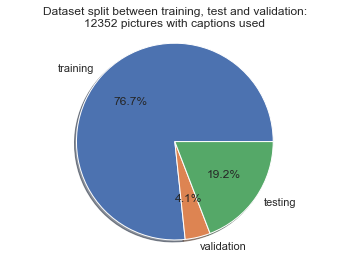

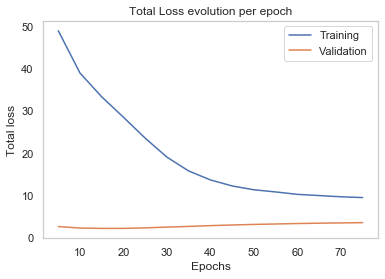

In [5]:


def plot_pie_chart(df, col_name, directory="./data/"):
    counts = df[col_name].value_counts()
    labels = [label for label in counts.axes[0]]
    sizes = [size for size in counts]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
    ax1.axis('equal')
    plt.title(str(col_name) + ": class distribution")
    save_path = os.path.join(directory, f"{str(col_name)}.png")
    plt.savefig(save_path)

    
pd.DataFrame({"data"})

fig1, ax1 = plt.subplots()
train_size = len(train_loader)*hparams["batch_size"]
val_size = len(val_loader)*hparams["batch_size"]
test_size = len(test_loader)*hparams["batch_size"]
ax1.pie([train_size,val_size,test_size], labels=["training","validation","testing"], autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title(f"Dataset split between training, test and validation:\n{train_size+val_size+test_size} pictures with captions used")
#plt.savefig("pie_chart.png")
plt.show()


train_loss_file = "loss_lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo75_bat32_do0_cut2_can5_with_norm_ie_s.pt.json"
val_loss_file= "val_loss_lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo75_bat32_do0_cut2_can5_with_norm_ie_s.pt.json"

# list of lists. The first entry is the epoch, the second is the corresponding total loss
train_loss = prep.read_json_config(os.path.join(hparams["model_storage"],train_loss_file))
val_loss = prep.read_json_config(os.path.join(hparams["model_storage"],val_loss_file))

df_loss = pd.DataFrame({"epochs": np.array([data[0]for data in train_loss]), "training_loss":np.array([data[1]for data in train_loss]), "validation_loss":np.array([data[1] for data in val_loss])})

ax = sns.lineplot( x="epochs", y="training_loss" ,data=df_loss, label="Training")
ax2 = sns.lineplot( x="epochs", y="validation_loss" ,data=df_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Total loss")
plt.title("Total Loss evolution per epoch") # You can comment this line out if you don't need title
#plt.savefig("loss_graph.png")
plt.show(ax2)


## Configure data for predictions

In [6]:
name="val"
train_file = hparams[name]
image_dir = os.path.join(hparams['root'], train_file)
caption_file_path = prep.get_correct_annotation_file(hparams, name)
device = hparams["device"]
if not torch.cuda.is_available():
    print("Warning, only CPU processing available!")
    device = "cpu"
else:
    print("CUDA GPU is available", "Number of machines:", torch.cuda.device_count())


#START PARAMETERS to adapt if needed
model_to_load="lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo75_bat32_do0_cut2_can5_with_norm_ie_s.pt"
hidden_dim=512
cnn_model="resnet50"
rnn_layers=3
rnn_model="gru"
drop_out_prob=0
num_image_to_show=50
#END PARAMETERS to adapt if needed




CUDA GPU is available Number of machines: 1


## Predictions...

Using resnet50...

Load temporary model:  ../model_storage\lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo75_bat32_do0_cut2_can5_with_norm_ie_s.pt
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!



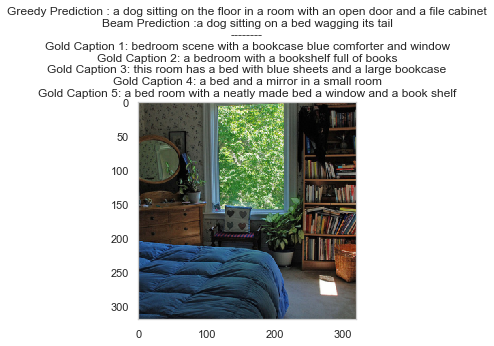

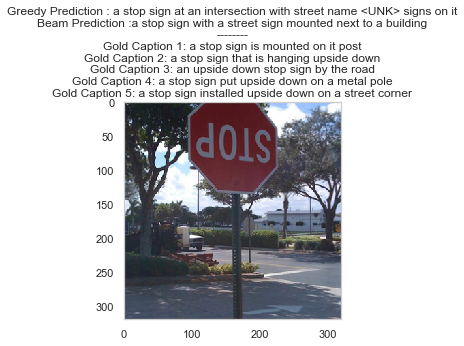

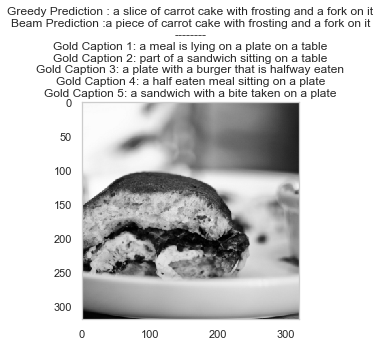

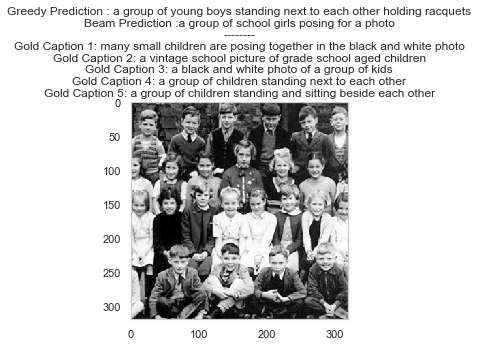

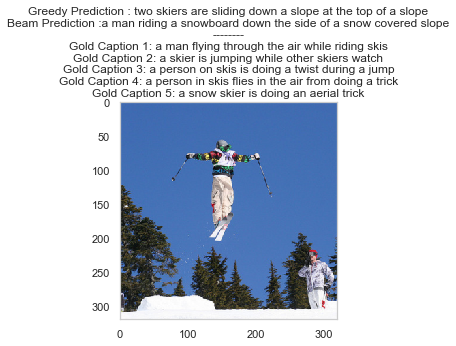

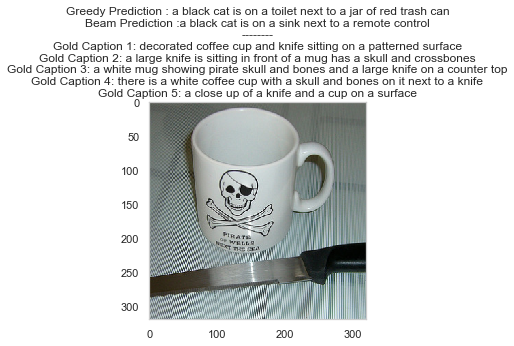

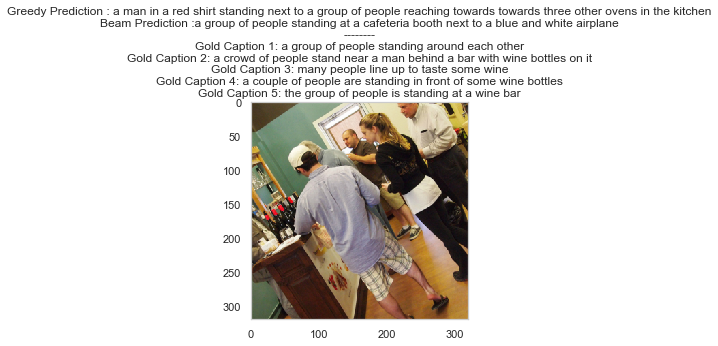

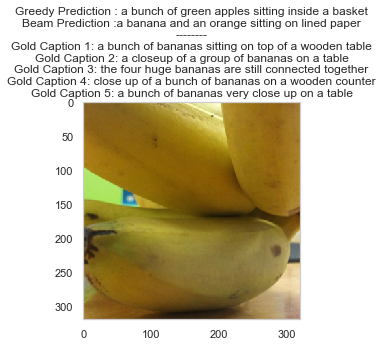

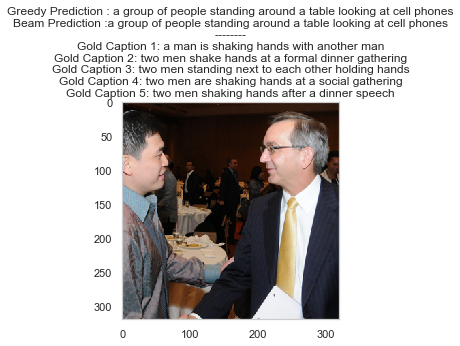

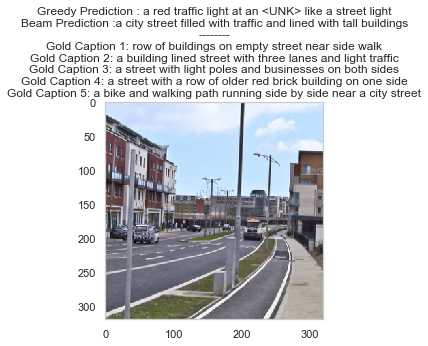

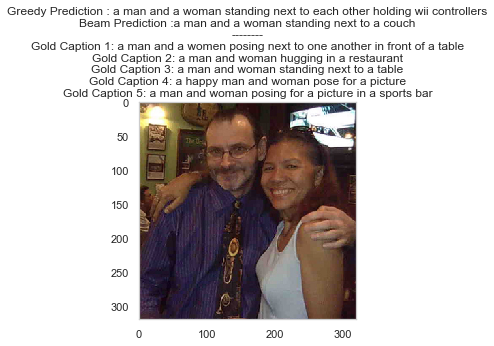

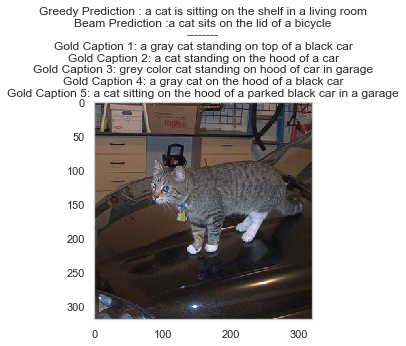

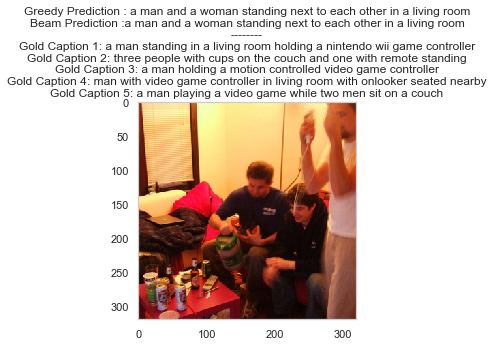

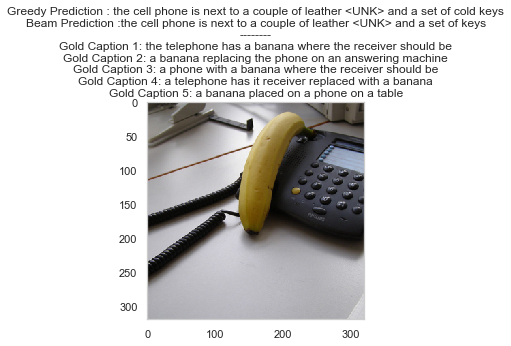

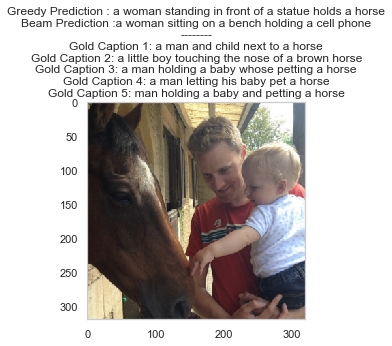

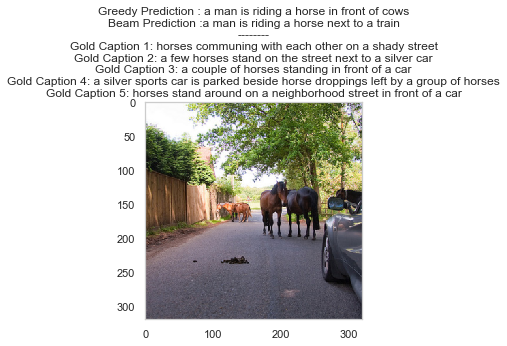

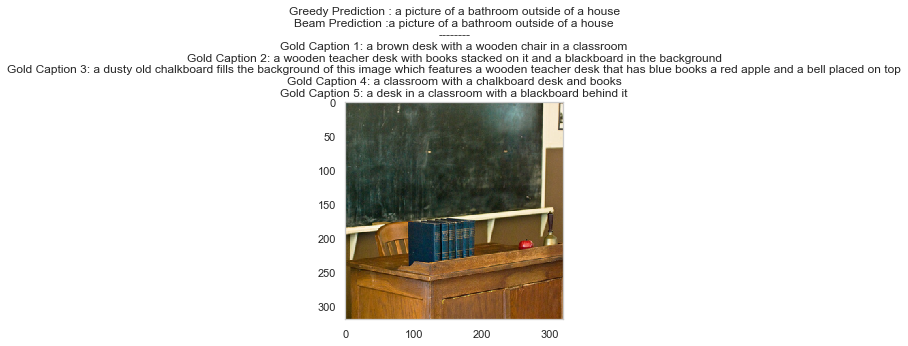

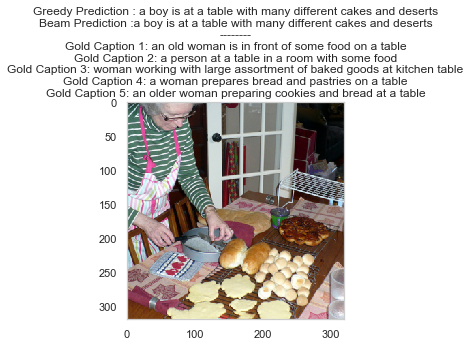

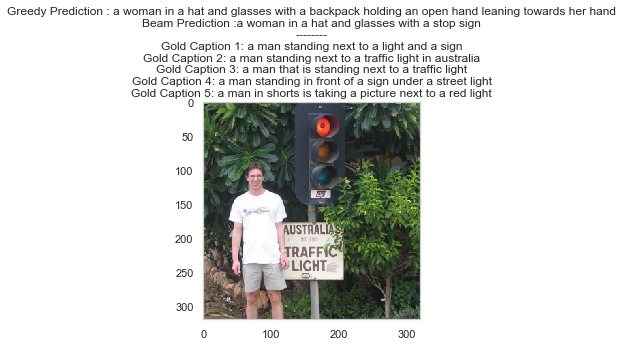

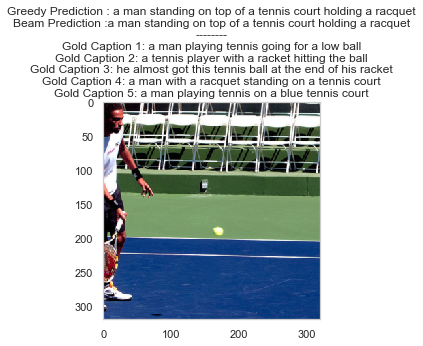

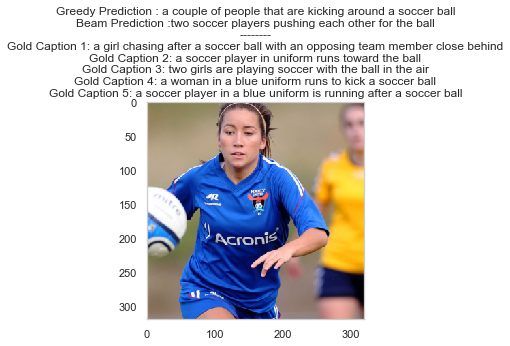

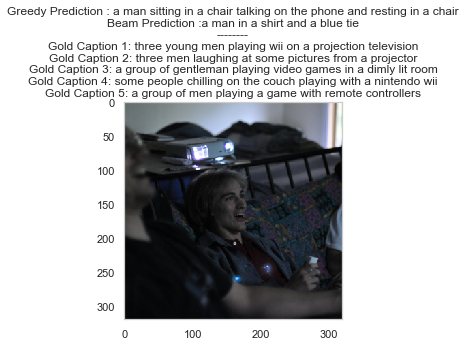

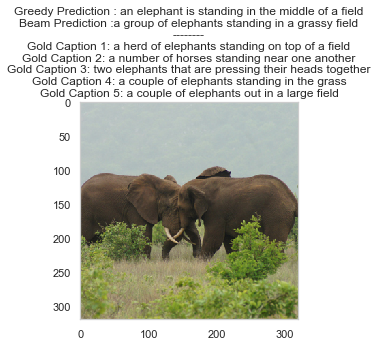

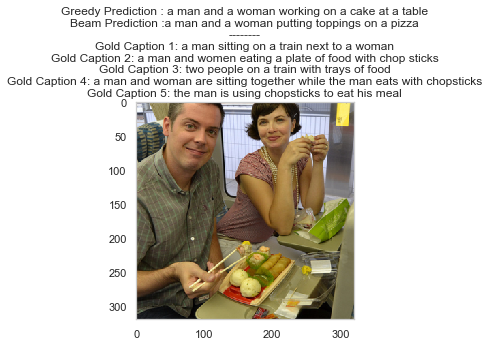

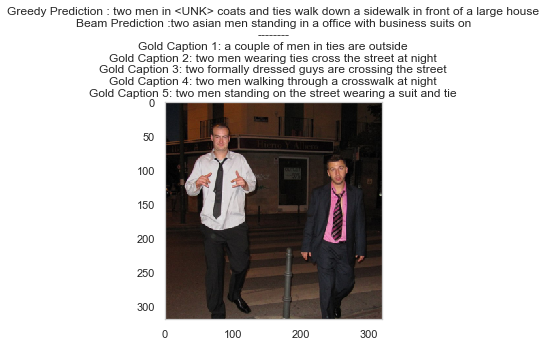

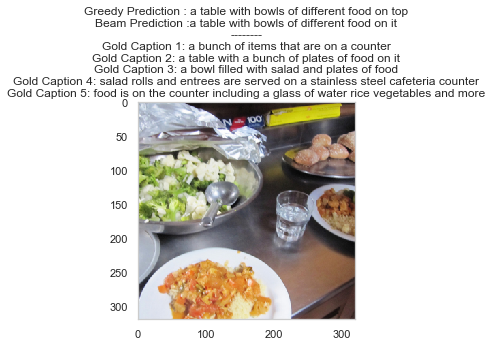

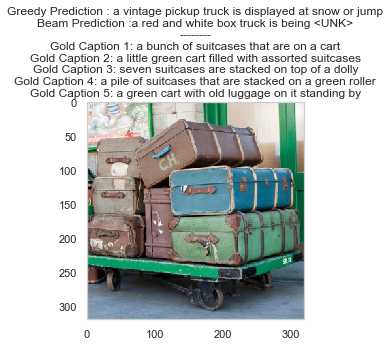

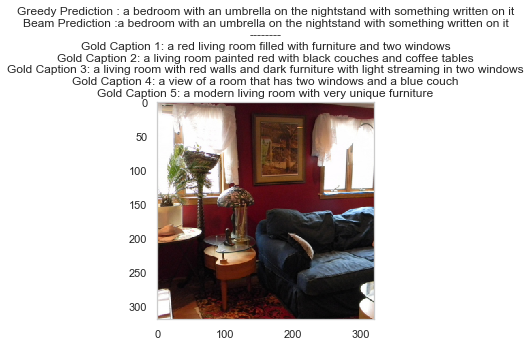

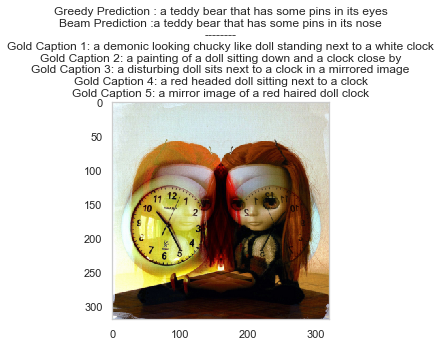

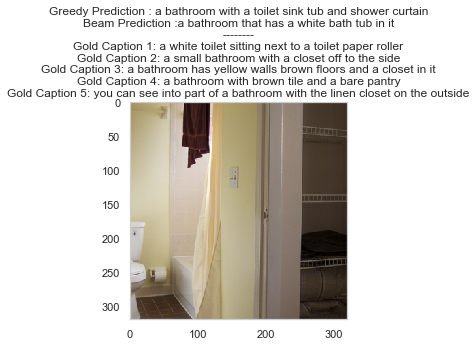

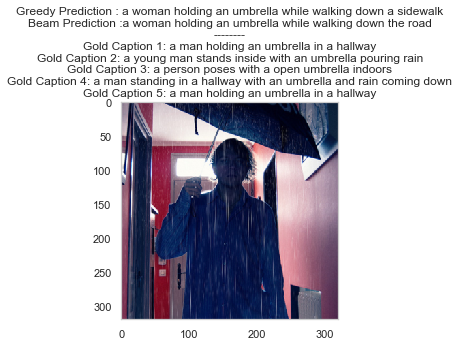

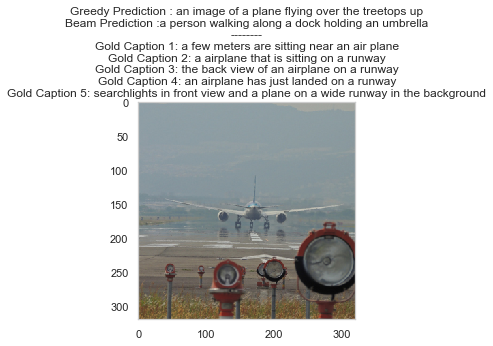

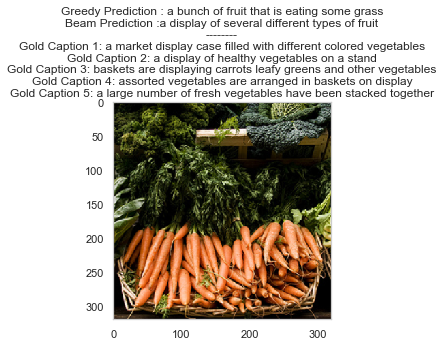

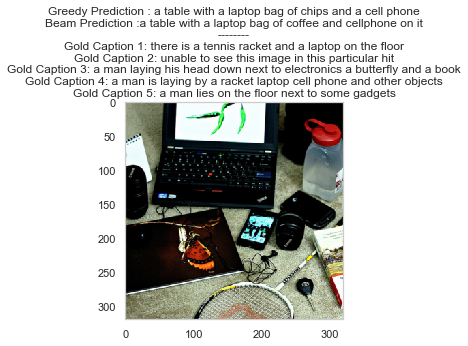

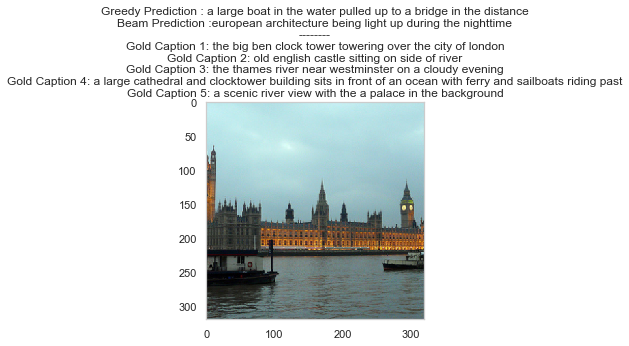

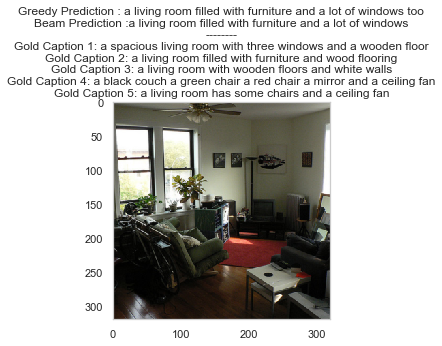

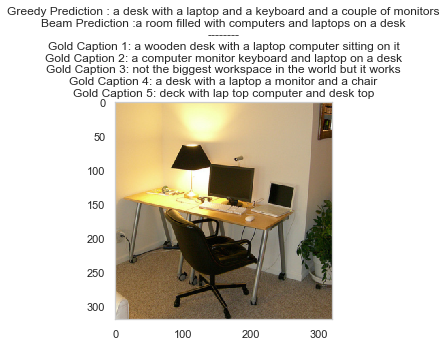

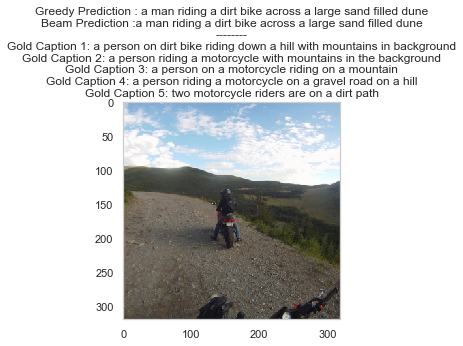

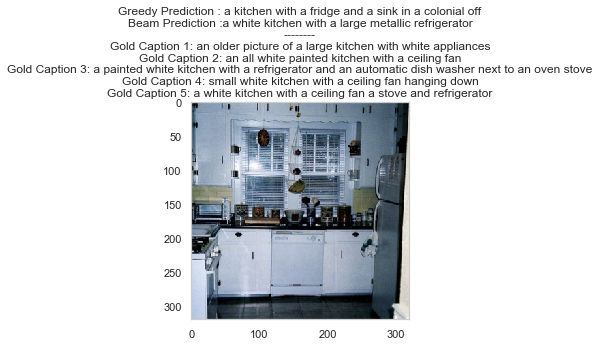

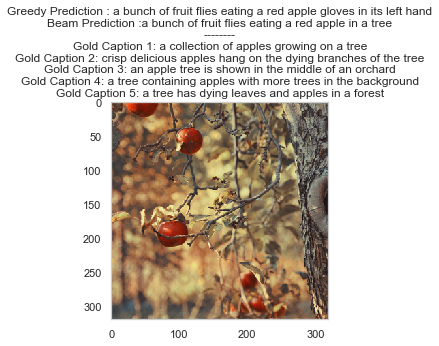

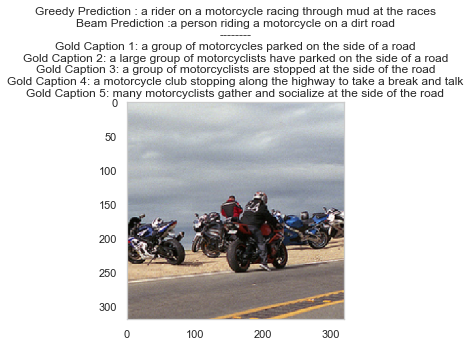

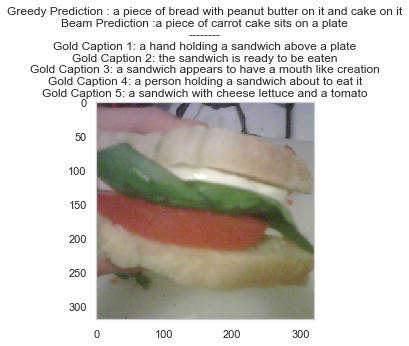

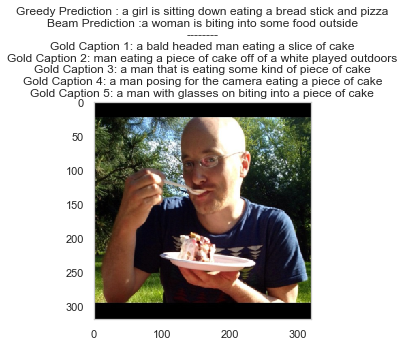

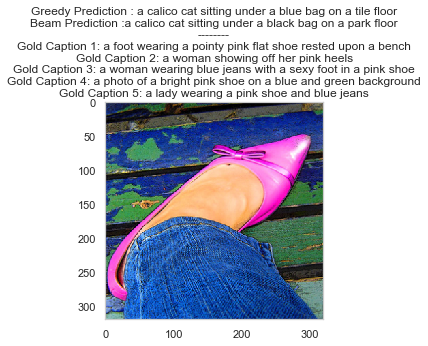

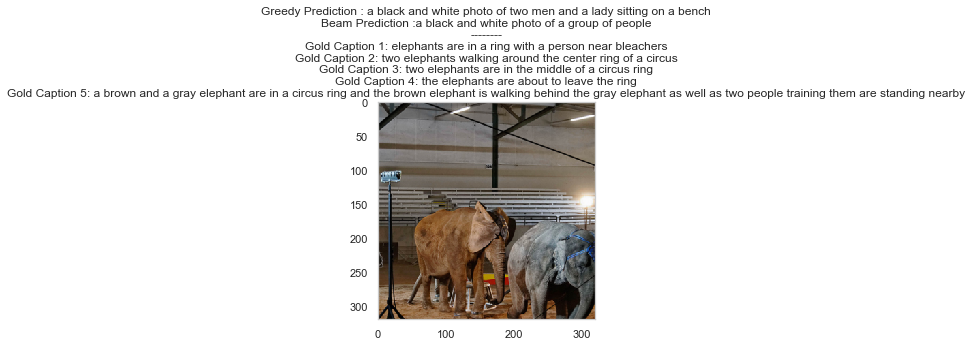

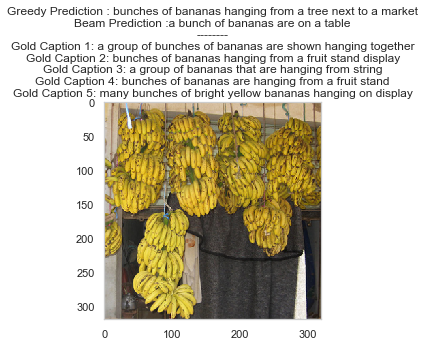

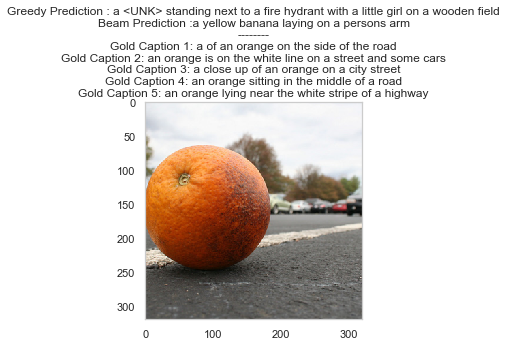

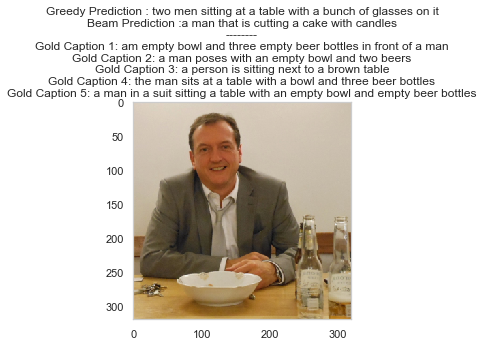

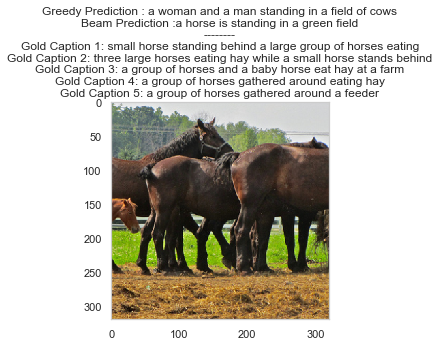

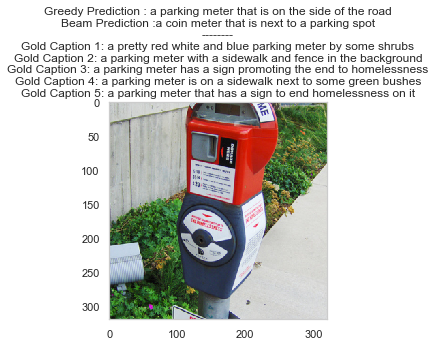

In [9]:
#Just to switch off the grid effect in seaborn plotting
sns.set_style("whitegrid", {'axes.grid' : False})

network = model.RNNModel(hidden_dim, pretrained_embeddings=embedding,
                             cnn_model=cnn_model, rnn_layers=rnn_layers,
                             rnn_model=rnn_model, drop_out_prob=drop_out_prob,
                             improve_cnn=False).to(device)
last_model = os.path.join(hparams["model_storage"], model_to_load)
if os.path.isfile(last_model):
    print("\nLoad temporary model: ", last_model)
    network.load_state_dict(torch.load(last_model))
else:
    print("\nWARNING!!!!!! Temporary model cannot be loaded", last_model)

transform_without_norm = transforms.Compose([transforms.Resize(hparams["image_size"]),
                                     transforms.CenterCrop(hparams["crop_size"]),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                    ])
coco_val_t = dset.CocoDetection(root=image_dir,
                                    annFile=caption_file_path,
                                    transform=transform_without_norm
                                    )
#val_loader_no_transform = torch.utils.data.DataLoader(coco_val_t, batch_size=hparams["batch_size"])

transform = transforms.Compose([transforms.Resize(hparams["image_size"]),
                                     transforms.CenterCrop(hparams["crop_size"]),
                                     transforms.ToTensor()
                                    ])
coco_val = dset.CocoDetection(root=image_dir,
                                    annFile=caption_file_path,
                                    transform=transform
                                    )
#val_loader = torch.utils.data.DataLoader(coco_val, batch_size=hparams["batch_size"])

iter_val= iter(coco_val)
iter_val_t= iter(coco_val_t)


for idx in range(num_image_to_show):
    original_img, _ = next(iter_val)
    transformed_img, annotations = next(iter(iter_val_t))
    starting_token = vectorizer.create_starting_sequence().unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    model_input = (transformed_img.unsqueeze(dim=0).to(device),starting_token)
    predicted_label_greedy = network.predict_greedy(model_input)
    predicted_label_beam = network.predict_beam_early_stop(model_input)
    prediction_greedy = vectorizer.decode(predicted_label_greedy[0][0])
    prediction_beam = vectorizer.decode(predicted_label_beam[0][0])
    print()
    plt.imshow(original_img.permute(1,2,0))
    gold = ""
    for caption_idx in range(hparams["caption_number"]):
        gold += "\n"+"Gold Caption "+str(caption_idx+1)+": "+annotations[caption_idx]["caption"]
    plt.title("Greedy Prediction : "+ prediction_greedy+"\nBeam Prediction :"+ prediction_beam+"\n--------"+gold)
    plt.show()